本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形
[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．
1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
1. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
1. 抽出された事例をランダムに並び替える．
1. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [1]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split
seed = 42

df = pd.read_table('NewsAggregatorDataset/newsCorpora.csv', header=None)
df.columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME','TIMESTAMP']

df = df.query(
    "PUBLISHER in ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']"
)
df = df[['CATEGORY', 'TITLE']]
df = df.replace({
    'CATEGORY': {
        'b': 0,
        't': 1,
        'e': 2,
        'm': 3
    }
})
df = df.sample(frac=1, random_state=seed)

X = df.copy()
y = X['CATEGORY']

X_train, X_vt, y_train, y_vt = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)
X_valid, X_test, y_valid, y_test = train_test_split(X_vt, y_vt, test_size=0.5, stratify=y_vt, random_state=seed)

X_train.to_csv('train.txt', encoding='utf-8', sep='\t', header=False, index=False)
X_valid.to_csv('valid.txt', encoding='utf-8', sep='\t', header=False, index=False)
X_test.to_csv('test.txt', encoding='utf-8', sep='\t', header=False, index=False)


def check(path):
    with open(path, encoding='utf-8') as f:
        rows = f.readlines()
    print(path)
    print(f'  length : {len(rows)}')
    print(f'  example: {rows[0].rstrip()}')


check('train.txt')
check('valid.txt')
check('test.txt')

train.txt
  length : 10672
  example: 2	How Kevin Costner Is Spending The 'Field Of Dreams' Anniversary
valid.txt
  length : 1334
  example: 2	Andrew Garfield - Andrew Garfield's fatherly fears
test.txt
  length : 1344
  example: 3	UPDATE 2-Peace Corps pulls volunteers from West Africa due to Ebola


## 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれ`train.feature.txt`，`valid.feature.txt`，`test.feature.txt`というファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [2]:
import joblib
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
cols = ['CATEGORY', 'TITLE']

train = pd.read_table('train.txt', header=None)
valid = pd.read_table('valid.txt', header=None)
test = pd.read_table('test.txt', header=None)
train.columns = cols
valid.columns = cols
test.columns = cols

vectorizer = TfidfVectorizer()
vectorizer.fit(train['TITLE'])
joblib.dump(vectorizer.get_feature_names(), 'vocab.joblib')

X_train = vectorizer.transform(train['TITLE'])
X_valid = vectorizer.transform(valid['TITLE'])
X_test = vectorizer.transform(test['TITLE'])

train = pd.concat([train, pd.DataFrame(X_train.toarray())], axis=1).drop(cols, axis=1)
valid = pd.concat([valid, pd.DataFrame(X_valid.toarray())], axis=1).drop(cols, axis=1)
test = pd.concat([test, pd.DataFrame(X_test.toarray())], axis=1).drop(cols, axis=1)

train.to_csv('train.feature.txt', sep='\t', header=False, index=False)
valid.to_csv('valid.feature.txt', sep='\t', header=False, index=False)
test.to_csv('test.feature.txt', sep='\t', header=False, index=False)

## 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [3]:
import pandas as pd

X_train = pd.read_table('train.feature.txt', header=None)
y_train = pd.read_table('train.txt', header=None)[0]
X_valid = pd.read_table('valid.feature.txt', header=None)
y_valid = pd.read_table('valid.txt', header=None)[0]
X_test = pd.read_table('test.feature.txt', header=None)
y_test = pd.read_table('test.txt', header=None)[0]

In [4]:
import joblib
from sklearn.linear_model import LogisticRegression
seed = 42

clf = LogisticRegression(solver='sag', random_state=seed)
clf.fit(X_train, y_train)

joblib.dump(clf, 'model.joblib')

['model.joblib']

## 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [5]:
import joblib


class Model:
    def __init__(self, clf_path):
        self.clf = joblib.load(clf_path)

    def predict(self, vector):
        return self.clf.predict(vector)


model = Model('model.joblib')

## 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [6]:
import pandas as pd
from sklearn.metrics import accuracy_score

preds_train = model.predict(X_train)
acc_train = accuracy_score(y_train, preds_train)

preds_test = model.predict(X_test)
acc_test = accuracy_score(y_test, preds_test)

print(f'学習データの正解率: {acc_train}')
print(f'評価データの正解率: {acc_test}')

学習データの正解率: 0.9446214392803598
評価データの正解率: 0.8853073463268366


## 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [7]:
import pandas as pd
from sklearn.metrics import confusion_matrix

preds_train = model.predict(X_train)
cm_train = confusion_matrix(y_train, preds_train)

preds_test = model.predict(X_test)
cm_test = confusion_matrix(y_test, preds_test)

In [8]:
print('（学習データ）左: 正解ラベル - 上: 推論結果')
pd.DataFrame(cm_train)

（学習データ）左: 正解ラベル - 上: 推論結果


,0,1,2,3
0,4413,35,51,3
1,154,948,115,2
2,19,5,4199,0
3,81,4,122,521


In [9]:
print('（評価データ）左: 正解ラベル - 上: 推論結果')
pd.DataFrame(cm_test)

（評価データ）左: 正解ラベル - 上: 推論結果


,0,1,2,3
0,526,9,26,2
1,39,87,25,1
2,9,1,518,0
3,20,1,20,50


## 56. 適合率，再現率，F1スコアの計測Permalink
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [10]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score

preds_test = model.predict(X_test)

print(f'適合率                : {precision_score(y_test, preds_test, average=None)}')
print(f"適合率（マイクロ平均）: {precision_score(y_test, preds_test, average='micro')}")
print(f"適合率（マクロ平均）  : {precision_score(y_test, preds_test, average='macro')}")
print('-----------------')
print(f'再現率                : {recall_score(y_test, preds_test, average=None)}')
print(f"再現率（マイクロ平均）: {recall_score(y_test, preds_test, average='micro')}")
print(f"再現率（マクロ平均）  : {recall_score(y_test, preds_test, average='macro')}")
print('-----------------')
print(f'F1スコア                : {f1_score(y_test, preds_test, average=None)}')
print(f"F1スコア（マイクロ平均）: {f1_score(y_test, preds_test, average='micro')}")
print(f"F1スコア（マクロ平均）  : {f1_score(y_test, preds_test, average='macro')}")

適合率                : [0.88552189 0.8877551  0.87945671 0.94339623]
適合率（マイクロ平均）: 0.8853073463268366
適合率（マクロ平均）  : 0.8990324800649074
-----------------
再現率                : [0.93428064 0.57236842 0.98106061 0.54945055]
再現率（マイクロ平均）: 0.8853073463268366
再現率（マクロ平均）  : 0.7592900539988507
-----------------
F1スコア                : [0.90924806 0.696      0.92748433 0.69444444]
F1スコア（マイクロ平均）: 0.8853073463268366
F1スコア（マクロ平均）  : 0.8067942081987076


## 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [11]:
import joblib

vocab = joblib.load('vocab.joblib')
coef = abs(model.clf.coef_).mean(axis=0)
sort = sorted(zip(vocab, coef), key=lambda x: x[1])

print('重みの高い特徴量トップ10')
for up in sort[::-1][:10]:
    print(f'  {up}')

print('重みの低い特徴量トップ10')
for down in sort[:10]:
    print(f'  {down}')

重みの高い特徴量トップ10
  ('google', 2.7765540154741912)
  ('facebook', 2.416435084409068)
  ('apple', 2.3503472571960597)
  ('ebola', 2.3159634330562624)
  ('study', 1.9815774534112953)
  ('microsoft', 1.976858919921507)
  ('climate', 1.9292338674381755)
  ('update', 1.8847786640221444)
  ('cancer', 1.8683900799492426)
  ('fda', 1.7199091566408131)
重みの低い特徴量トップ10
  ('upstage', 0.0010412205051274848)
  ('active', 0.0017060165615213764)
  ('invitation', 0.0017592750195685833)
  ('tone', 0.0017671900396924313)
  ('outsell', 0.0019452002240825418)
  ('brushed', 0.0025754658933553466)
  ('sideboob', 0.0026272341334732646)
  ('choreograph', 0.002682934529096472)
  ('crypt', 0.0029919970066449087)
  ('extravagant', 0.0030894287680318256)


## 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

学習終わり: C=0.1
学習終わり: C=1
学習終わり: C=5
学習終わり: C=10


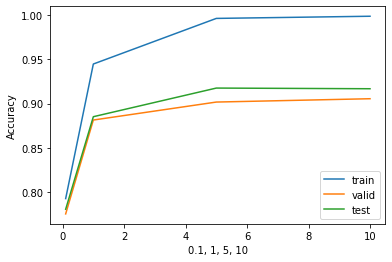

In [12]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
%matplotlib inline

seed = 42
Cs = [0.1, 1, 5, 10]

acc_train = []
acc_valid = []
acc_test = []
for C in Cs:
    clf = LogisticRegression(solver='sag', C=C, random_state=seed)
    clf.fit(X_train, y_train)

    acc_train.append(accuracy_score(y_train, clf.predict(X_train)))
    acc_valid.append(accuracy_score(y_valid, clf.predict(X_valid)))
    acc_test.append(accuracy_score(y_test, clf.predict(X_test)))
    print(f'学習終わり: C={C}')
    
plt.plot(Cs, acc_train, label='train')
plt.plot(Cs, acc_valid, label='valid')
plt.plot(Cs, acc_test, label='test')
plt.ylabel('Accuracy')
plt.xlabel(', '.join([str(C) for C in Cs]))
plt.legend()
plt.show()

## 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．